# Using EcoFOCIpy to process raw field data

## Mooring / Timeseries Data

Basic workflow for each instrument grouping is *(initial archive level)*:
- Parse data from raw files into pandas dataframe
- output initial files (pandas->csv) **ERDDAP NRT** when no meta data is added

Convert to xarray dataframe for all following work *(working or final data level):
- TODO: Add metadata from instrument yaml files and/or header info
- ingest metadata from deployment/recovery records or cast logs
- process data beyond simple file translate
- apply any calibrations or corrections
    + field corrections
    + offsets
    + instrument compensations
    + some QC were available... this would be old-school simple bounds mostly
- adjust time bounds and sample frequency (xarray dataframe)
- save as CF netcdf via xarray: so many of the steps above are optional
    + **ERDDAP NRT** if no corrections, offsets or time bounds are applied but some meta data is
    + **Working and awaiting QC** has no ERDDAP representation and is a holding spot
    + **ERDDAP Final** fully calibrated, qc'd and populated with meta information

Plot for preview and QC
- preview images (indiv and/or collectively)
- manual qc process
- automated qc process ML/AI

Further refinenments for ERDDAP hosting:


## Example below is for SBE-37 but the workflow is similar for all instruments.

Future processing of this instrument can be a simplified (no markdown) process which can be archived so that the procedure can be traced or updated

In [23]:
import yaml

import EcoFOCIpy.io.sbe_parser as sbe_parser #<- instrument specific
import EcoFOCIpy.io.ncCFsave as ncCFsave
import EcoFOCIpy.metaconfig.load_config as load_config

The sample_data_dir should be included in the github package but may not be included in the pip install of the package

## Simple Processing - first step

In [24]:
sample_data_dir = '../'

In [25]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = sample_data_dir+'staticdata/example_data/sbe37_wpress.cnv'
instrument = 'SBE-37 1807'
mooring_meta_file = sample_data_dir+'staticdata/mooring_example.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe37_cf.yaml'
inst_shortname = 's37'
###############################################################

#init and load data
sbe37_wop = sbe_parser.sbe37()
(sbe37_wop_data,sbe37_wop_header) = sbe37_wop.parse(filename=datafile,
                                                    return_header=True,
                                                    datetime_index=True) 

The data is output as a pandas dataframe from the intial module call and if its available, a header

In [26]:
sbe37_wop_header

['* Sea-Bird SBE37 Data File:\n',
 '* FileName = C:\\Users\\foci\\Documents\\2018\\fall_mooring_downloads\\sbe37_2355.asc\n',
 '* Software Version 1.59\n',
 '* Temperature SN = 2355\n',
 '* Conductivity SN = 2355\n',
 '* System UpLoad Time = Oct 04 2018 00:15:11\n',
 '** realtime: 001245\n',
 '** instime: 001312\n',
 '* ds\n',
 '* SBE37-SM V 2.6b  SERIAL NO. 2355    04 Oct 2018  00:14:32\n',
 '* not logging: received stop command\n',
 '* sample interval = 30 seconds\n',
 '* samplenumber = 110569, free = 80081\n',
 '* do not transmit real-time data\n',
 '* output salinity with each sample\n',
 '* do not output sound velocity with each sample\n',
 '* store time with each sample\n',
 '* number of samples to average = 4\n',
 '* serial sync mode disabled\n',
 '* wait time after serial sync sampling = 30 seconds\n',
 '* internal pump not installed\n',
 '* temperature = 10.41 deg C\n',
 '\n',
 '\n',
 '* S>\n',
 '* SBE37-SM V 2.6b  2355\n',
 '* temperature:  22-sep-17\n',
 '*     TA0 = -1.0235

In [27]:
sbe37_wop_data

,temperature,conductivity,pressure,salinity
date_time,,,,
2018-04-30 14:01:23,4.4372,0.00002,-0.094,0.0015
2018-04-30 14:01:53,4.4297,0.00002,-0.094,0.0015
2018-04-30 14:02:23,4.4209,0.00002,-0.094,0.0015
2018-04-30 14:02:53,4.4219,0.00001,-0.094,0.0015
2018-04-30 14:03:23,4.4187,0.00002,-0.094,0.0015
...,...,...,...,...
2018-05-02 10:49:53,3.6534,2.98133,53.396,32.0654
2018-05-02 10:50:23,3.6523,2.98122,53.201,32.0653
2018-05-02 10:50:53,3.6524,2.98123,53.236,32.0653


## Time properties

Its unusual that our clocks drift to the point of concern for our instruments (if an instrument is off by 3 minutes but only sampling hourly... regridding that data will result in minimal changes).  However, there are a few time oriented modifications that may need to be made.

It is very easy to use pandas interplation and resample methods on the dataframe as is.  A few steps are suggested below:
- parse out on-deck (predeployment and recovery) data.  This can be done via pandas or xarray but requires the mooring metadata to have been read in.  See future steps below.
- even if the sample frequency is set to the desired measurement frequency, it would be good to perform a quick regridding as an assurance task
- FOCI data is usualy 1min, 10min, 1hr - and the 1min data is a fairly new (sbe56) data stream
    + subsampling high frequency data to lower frequency is easy via df.resample().mean()
    + you may want to take the median instead of the mean for noisy data (fluorometer) , occasionally decimating may be more appropriate if you want to downsize the dataset size but not smear features
    + shifting times can be a bit more involved.  There are two primary ways to do it, interpolate or shift
        - to interpolate, you will need to upsample your data to a higher frequency which will generate missing values, then interpolate (with a maximum gap size), then decimate.  This always has the artifact of smoothing data and decreasing the min/max values. **common on microcats and other 10min datasets**
        - shifting usually just involves droping extra time "digits", if you want hourly, you could just drop the trailing minutes assuming you are just off the hour (8:05 -> 8:00) or you can round to the nearest time unit but niether of these changes the data value, just the time associated with it. **common on seacats and other hourly datasets**
    + I suggest if no change is needed... resample().mean() to the sample frequency just in case there is a small deviation from expected (<1min)
    

In [28]:
sbe37_wop_data = sbe37_wop_data.resample('10min').mean()
sbe37_wop_data

,temperature,conductivity,pressure,salinity
date_time,,,,
2018-04-30 14:00:00,4.414450,0.000012,-0.09400,0.001500
2018-04-30 14:10:00,4.399030,0.000010,-0.09400,0.001500
2018-04-30 14:20:00,4.390220,0.000010,-0.09400,0.001500
2018-04-30 14:30:00,4.371020,0.000010,-0.09400,0.001500
2018-04-30 14:40:00,4.330920,0.000010,-0.09400,0.001485
...,...,...,...,...
2018-05-02 10:10:00,3.649700,2.980922,53.10860,32.064325
2018-05-02 10:20:00,3.649100,2.980874,53.07035,32.064360
2018-05-02 10:30:00,3.649775,2.980958,53.13075,32.064670


<AxesSubplot:xlabel='date_time'>

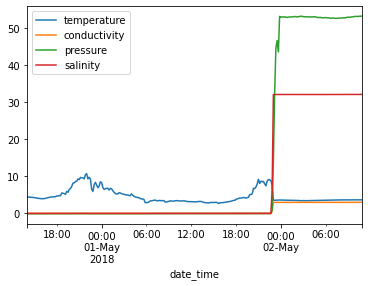

In [29]:
sbe37_wop_data.plot()

## Add Deployment meta information

Two methods are available (if comming from python2 world - ordereddict was important... in py38 a dictionary is inherently ordered)

In [30]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

## Add Instrument meta information

Time, depth, lat, lon should be added regardless (always our coordinates) but for a mooring site its going to be a (1,1,1,t) dataset
The variables of interest should be read from the data file and matched to a key for naming.  That key is in the inst_config file seen below and should represent common conversion names in the raw data

In [31]:
with open(inst_meta_file) as file:
    inst_config = yaml.full_load(file)

In [32]:
# Add meta data and prelim processing based on meta data
# Convert to xarray and add meta information - save as CF netcdf file
# pass -> data, instmeta, depmeta
sbe37_wop_nc = ncCFsave.EcoFOCI_CFnc_moored(df=sbe37_wop_data, 
                                instrument_yaml=inst_config, 
                                mooring_yaml=mooring_config, 
                                instrument_id=instrument, 
                                inst_shortname=inst_shortname)
sbe37_wop_nc

At this point, you could save your file with the `.xarray2netcdf_save()` method and have a functioning dataset.... but it would be very simple with no additional qc, meta-data, or tuned parameters for optimizing software like ferret or erddap.

In [33]:
# expand the dimensions and coordinate variables
# renames them appropriatley and prepares them for meta-filled values
sbe37_wop_nc.expand_dimensions()

In [34]:
sbe37_wop_nc.variable_meta_data(variable_keys=['temperature'])
sbe37_wop_nc.temporal_geospatioal_meta_data(depth='designed')
#adding dimension meta needs to come after updating the dimension values... BUG?
sbe37_wop_nc.dimension_meta_data(variable_keys=['depth','latitude','longitude'])

The following steps can happen in just about any order and are all meta-data driven.  Therefore, they are not required to have a functioning dataset, but they are required to have a well described dataset

In [35]:
#add global attributes
sbe37_wop_nc.deployment_meta_add()
sbe37_wop_nc.get_xdf()

#add instituitonal global attributes
sbe37_wop_nc.institution_meta_add()

#add creation date/time - provenance data
sbe37_wop_nc.provinance_meta_add()

#provide intial qc status field
sbe37_wop_nc.qc_status(qc_status='unknown')


## Save CF Netcdf files

Currently stick to netcdf3 classic... but migrating to netcdf4 (default) may be no problems for most modern purposes.  Its easy enough to pass the `format` kwargs through to the netcdf api of xarray.

In [36]:
# combine trim (not mandatory) and filename together (saves to test.nc without name)
sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.autotrim_time(),
                           filename=sbe37_wop_nc.filename_const(),format="NETCDF3_CLASSIC")

# don't trim the data and pass your own filename
sbe37_wop_nc.xarray2netcdf_save(xdf = sbe37_wop_nc.get_xdf(),
                           filename=sbe37_wop_nc.filename_const(manual_label='test'),format="NETCDF4_CLASSIC")

In [37]:
sbe37_wop_nc.get_xdf()

<xarray.Dataset>
Dimensions:       (depth: 1, latitude: 1, longitude: 1, time: 270)
Coordinates:
  * time          (time) datetime64[ns] 2018-04-30T14:00:00 ... 2018-05-02T10...
  * longitude     (longitude) float64 -164.0
  * latitude      (latitude) float64 56.87
  * depth         (depth) float64 60.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 4.414 ... 3.652
    conductivity  (time, depth, latitude, longitude) float64 1.222e-05 ... 2.981
    pressure      (time, depth, latitude, longitude) float64 -0.094 ... 53.17
    salinity      (time, depth, latitude, longitude) float64 0.0015 ... 32.07
Attributes: (12/13)
    Latitude-Deg_MM.dd_W:                   56 52.1729 N
    Longitude-Deg_MM.dd_N:                  164 02.8716 W
    MooringID:                              16BSM-2A
    platform_deployment_date:               2016-05-05T05:51:00Z
    platform_deployment_cruise_name:        DY1606
    platform_recovery_date:                 2016-09-29T03:45:00Z
    ...                                     ...
    platform_deployment_recovery_comments:  Depth not listed - other two moor...
    WaterDepth:                             71.0
    date_created:                           2021-03-30T16:30:48Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history